In [158]:
from lightglue import LightGlue, SIFT, viz2d
from lightglue.utils import load_image, rbd
import torch
import numpy as np
from scipy.stats import wasserstein_distance # Will need this if we use wasserstein
import re
import time
import pickle
import pandas as pd
import random
import matplotlib.pyplot as plt

from pathlib import Path

In [2]:
torch.set_grad_enabled(False)

In [3]:
# Use GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 'mps', 'cpu'

In [4]:
def load_split(size: str = "nano") -> pd.DataFrame:
    split_filepath = Path(f"../../../data/04_feature/bearidentification/bearid/split/by_individual/{size}/data_split.csv")
    return pd.read_csv(split_filepath, sep=";")

def draw_triplet_from(df: pd.DataFrame, random_seed: int = 42) -> dict[str, Path]:
    random.seed(random_seed)
    bear_ids = set(df.bear_id.unique().tolist())
    anchor_bear_id = random.choice(list(bear_ids))
    bear_ids_without_anchor_bear_id = bear_ids - set([anchor_bear_id])
    negative_bear_id = random.choice(list(bear_ids_without_anchor_bear_id))

    df_pos = df[df["bear_id"] == anchor_bear_id]
    df_neg = df[df["bear_id"] == negative_bear_id]

    df_pos_sample = df_pos.sample(n=2, random_state=random_seed)
    anchor_path, positive_path = df_pos_sample.iloc[0]["path"], df_pos_sample.iloc[1]["path"]

    df_neg_sample = df_neg.sample(n=1, random_state=random_seed)
    negative_path =  df_neg_sample.iloc[0]["path"]


    return {
        "anchor": anchor_path, 
        "positive": positive_path, 
        "negative": negative_path,
    }

In [181]:
def visualize_matching(path0: Path, path1: Path, features_dict: dict, matcher) -> None:
    image0 = load_image(Path("../../../") / path0)
    image1 = load_image(Path("../../../") / path1)
    
    feats0 = features_dict[path0]
    feats1 = features_dict[path1]
    
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    feats0, feats1, matches01 = [rbd(x) for x in [feats0, feats1, matches01]]  # remove batch dimension

    matches = matches01['matches']  # indices with shape (K,2)
    points0 = feats0['keypoints'][matches[..., 0]]  # coordinates in image #0, shape (K,2)
    points1 = feats1['keypoints'][matches[..., 1]]  # coordinates in image #1, shape (K,2)

    axes = viz2d.plot_images([image0, image1])
    viz2d.plot_matches(points0, points1, color="lime", lw=0.2)
    viz2d.add_text(0, f'Stop after {matches01["stop"]} layers', fs=20)

def visualize_triplet_images(anchor_path: Path, positive_path: Path, negative_path: Path) -> None:
    anchor_image = load_image(Path("../../../") / anchor_path)
    positive_image = load_image(Path("../../../") / positive_path)
    negative_image = load_image(Path("../../../") / negative_path)
    
    viz2d.plot_images([anchor_image, positive_image, negative_image], titles=["anchor", "positive", "negative"])

def visualize_triplet(anchor_path: Path, positive_path: Path, negative_path: Path, features_dict: dict, matcher) -> None:
    visualize_triplet_images(anchor_path, positive_path, negative_path)
    visualize_matching(anchor_path, positive_path, features_dict, matcher)
    visualize_matching(anchor_path, negative_path, features_dict, matcher)


def load(extractor_type: str = "sift", n_keypoints: int = 1024) -> dict:
    features_filepath = Path(f"../../../data/04_feature/bearidentification/lightglue/8a505e53d07ef04bda85260ece34238d/{extractor_type}/{n_keypoints}/features.pth")
    features_dict = torch.load(features_filepath)
    matcher = LightGlue(features='sift').eval()
    return {"features_dict": features_dict, "matcher": matcher}

In [182]:
extractor_type = "sift"
sift_data = load(extractor_type=extractor_type)
matcher = sift_data["matcher"]
features_dict = sift_data["features_dict"]

In [183]:
df_split = load_split()
df_split.head()

origin  encounter bear_id                                   image  \
0  brooksFalls  je_201708  bf_480              480-otis_14592316682_o.jpg   
1  brooksFalls  je_201708  bf_480              480-otis_10234355613_o.jpg   
2  brooksFalls  je_201708  bf_480               480-otis_9382835168_o.jpg   
3  brooksFalls  je_201708  bf_480  480-otis-in-far-pool_11332560345_o.jpg   
4  brooksFalls  je_201708  bf_480              480-otis_10234289115_o.jpg   

                                                path  split  
0  data/07_model_output/bearfacesegmentation/chip...  train  
1  data/07_model_output/bearfacesegmentation/chip...  train  
2  data/07_model_output/bearfacesegmentation/chip...  train  
3  data/07_model_output/bearfacesegmentation/chip...  train  
4  data/07_model_output/bearfacesegmentation/chip...  train

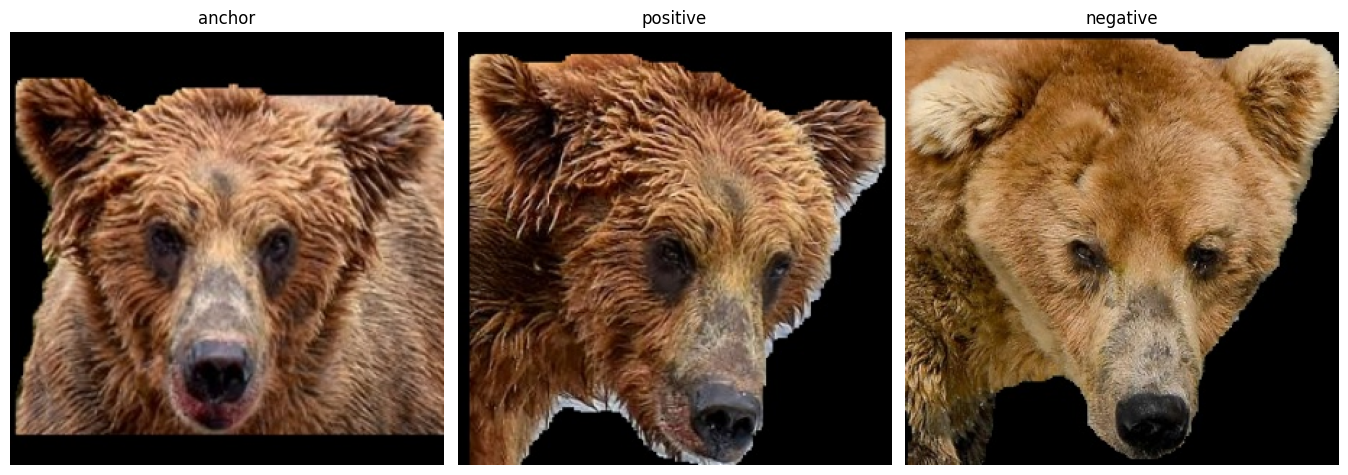

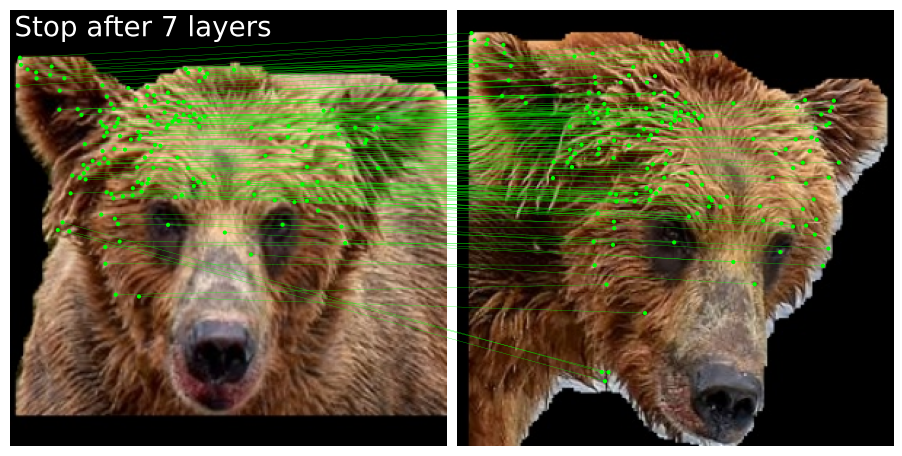

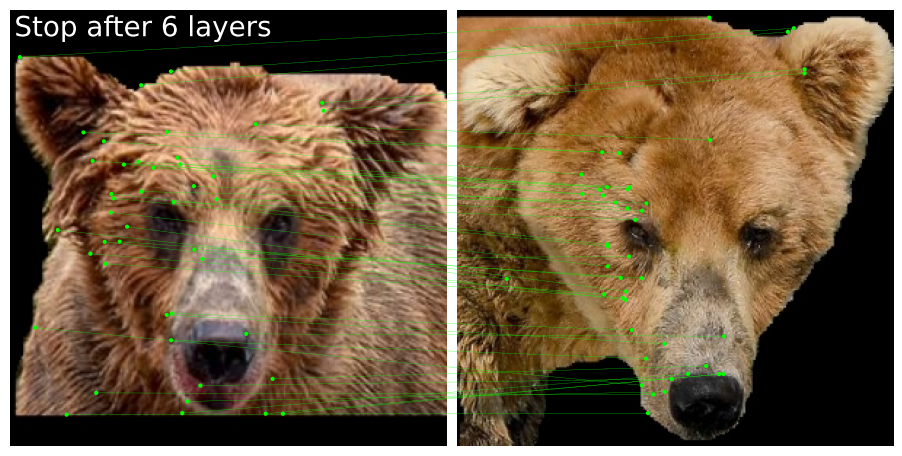

In [184]:
triplet = draw_triplet_from(df_split)
anchor_path, positive_path, negative_path = triplet["anchor"], triplet["positive"], triplet["negative"]
visualize_triplet(anchor_path=anchor_path, positive_path=positive_path, negative_path=negative_path, features_dict=features_dict, matcher=matcher)

In [164]:
def cumulative_distribution(x):
  n_scores = len(x)
  x_sort = np.sort(x)
  y = np.arange(n_scores) / float(n_scores)
  return x_sort, y

# Normalize x_sort between 0 and 1
def cumulative_distribution2(x):
    n_scores = len(x)
    x_sort = np.sort(x)
    y = np.arange(n_scores) / float(n_scores)
    return x_sort / x_sort[-1], y


def cumulative_distribution3(x, num_elems: int = 1000):
    idx = np.round(np.linspace(0, len(x) - 1, num_elems)).astype(int)
    n_scores = len(x)
    x_sort = np.sort(x)
    new_x_sort = x_sort[idx]
    y = np.arange(num_elems) / float(num_elems)
    
    return new_x_sort / x_sort[-1], y

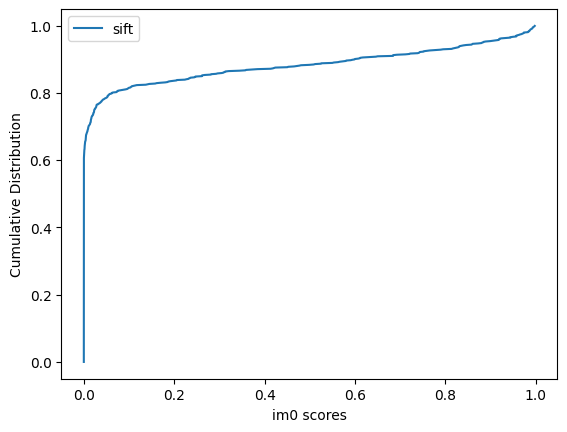

In [165]:
feats0 = features_dict[anchor_path]
feats1 = features_dict[positive_path]
matches01 = matcher({'image0': feats0, 'image1': feats1})
im0_scores = matches01["matching_scores0"][0]

x_sort, y = cumulative_distribution(im0_scores)
plt.plot(x_sort,y, label='sift')
plt.xlabel('im0 scores')
plt.ylabel('Cumulative Distribution')
plt.legend()

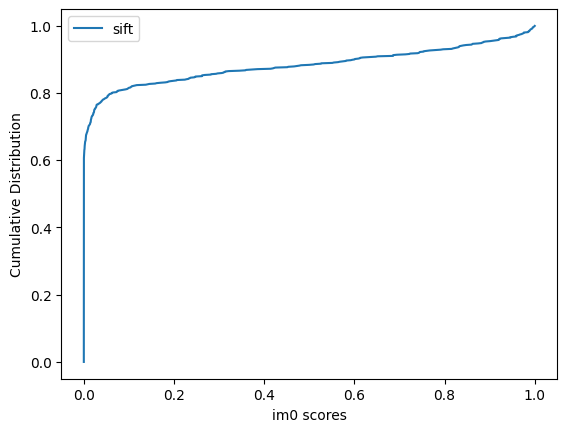

In [166]:
feats0 = features_dict[anchor_path]
feats1 = features_dict[positive_path]
matches01 = matcher({'image0': feats0, 'image1': feats1})
im0_scores = matches01["matching_scores0"][0]

x_sort, y = cumulative_distribution2(im0_scores)
plt.plot(x_sort,y, label='sift')
plt.xlabel('im0 scores')
plt.ylabel('Cumulative Distribution')
plt.legend()

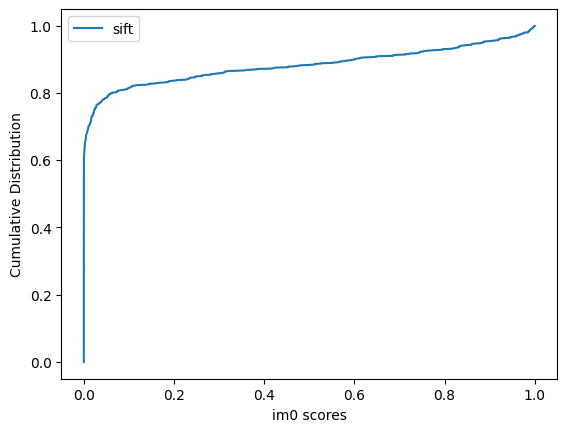

In [167]:
feats0 = features_dict[anchor_path]
feats1 = features_dict[positive_path]
matches01 = matcher({'image0': feats0, 'image1': feats1})
im0_scores = matches01["matching_scores0"][0]

x_sort, y = cumulative_distribution3(im0_scores)
plt.plot(x_sort,y, label='sift')
plt.xlabel('im0 scores')
plt.ylabel('Cumulative Distribution')
plt.legend()

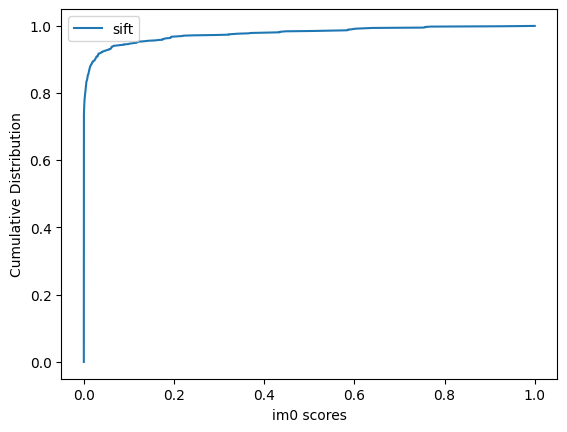

In [168]:
feats0 = features_dict[anchor_path]
feats1 = features_dict[negative_path]
matches01 = matcher({'image0': feats0, 'image1': feats1})
im0_scores = matches01["matching_scores0"][0]

x_sort, y = cumulative_distribution3(im0_scores)
plt.plot(x_sort,y, label='sift')
plt.xlabel('im0 scores')
plt.ylabel('Cumulative Distribution')
plt.legend()

In [169]:
from scipy.integrate import simpson
from numpy import trapz
from sklearn.metrics import auc

In [173]:
feats0 = features_dict[anchor_path]
feats1 = features_dict[negative_path]
matches01 = matcher({'image0': feats0, 'image1': feats1})
im0_scores = matches01["matching_scores0"][0]
x_sort, y = cumulative_distribution2(im0_scores)

auc(x_sort, y)

0.9764964982575074

In [174]:
feats0 = features_dict[anchor_path]
feats1 = features_dict[positive_path]
matches01 = matcher({'image0': feats0, 'image1': feats1})
im0_scores = matches01["matching_scores0"][0]
x_sort, y = cumulative_distribution2(im0_scores)

auc(x_sort, y)

0.8817038300985038

In [178]:
def evaluate_auc_pair(feats0, feats1, matcher, legend: str = "positive matching") -> None:
    matches01 = matcher({'image0': feats0, 'image1': feats1})
    im0_scores = matches01["matching_scores0"][0]
    x_sort, y = cumulative_distribution3(im0_scores)
    auc_result = auc(x_sort, y)
    
    plt.plot(x_sort,y, label=f'{legend} - auc: {auc_result}')
    plt.xlabel('im0 scores')
    plt.ylabel('Cumulative Distribution')
    plt.legend()
    

def evaluate_auc_triplet(triplet: dict, matcher) -> None:
    anchor_path, positive_path, negative_path = triplet["anchor"], triplet["positive"], triplet["negative"]
    evaluate_auc_pair(feats0=features_dict[anchor_path], feats1=features_dict[positive_path], matcher=matcher, legend="positive matching")
    evaluate_auc_pair(feats0=features_dict[anchor_path], feats1=features_dict[negative_path], matcher=matcher, legend="negative matching")

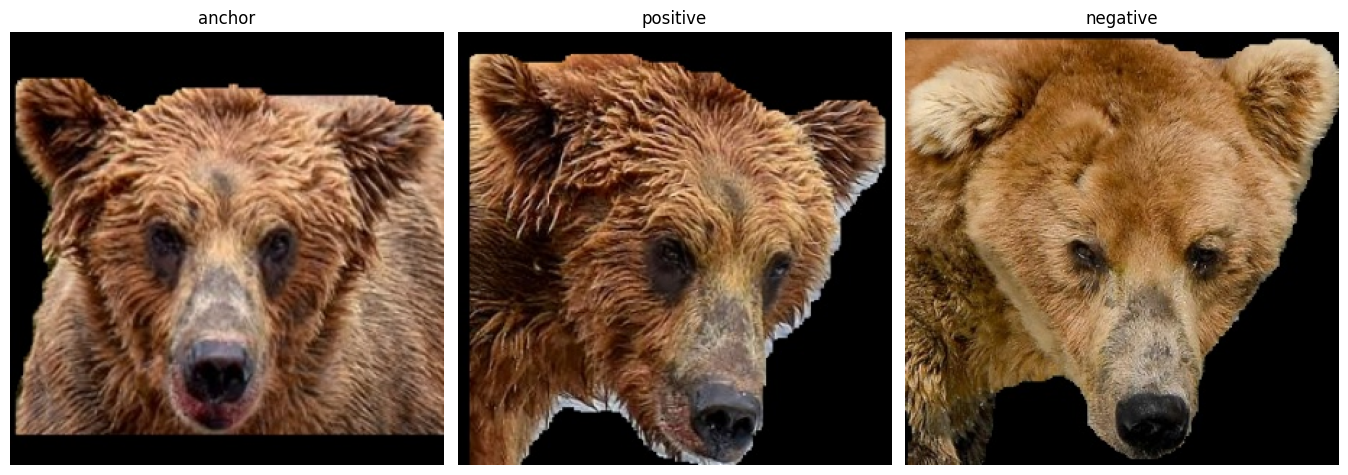

In [190]:
triplet = draw_triplet_from(df=df_split)
anchor_path, positive_path, negative_path = triplet["anchor"], triplet["positive"], triplet["negative"]
visualize_triplet_images(anchor_path, positive_path, negative_path)

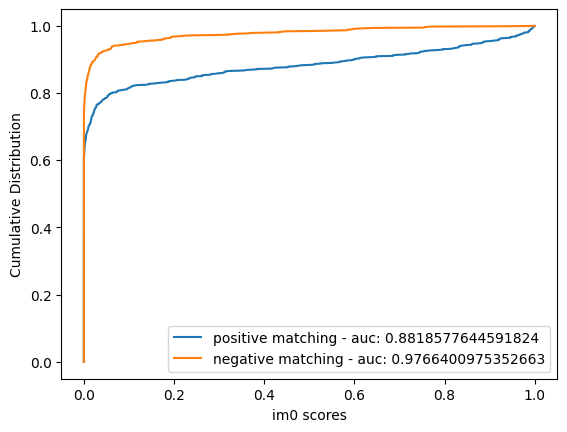

In [187]:
evaluate_auc_triplet(triplet, matcher)

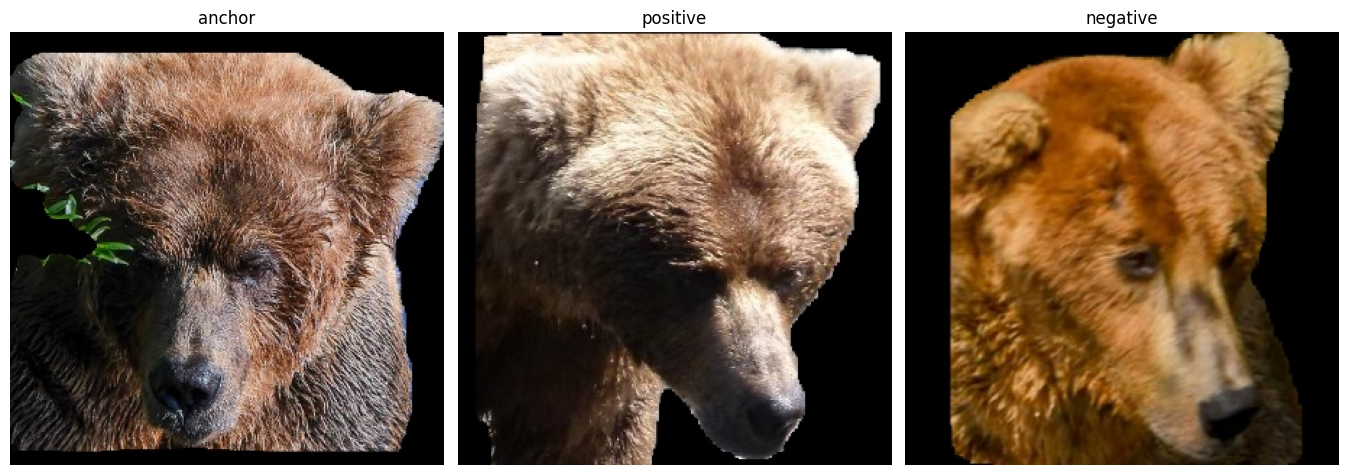

In [196]:
triplet = draw_triplet_from(df=df_split, random_seed=1)
anchor_path, positive_path, negative_path = triplet["anchor"], triplet["positive"], triplet["negative"]
visualize_triplet_images(anchor_path, positive_path, negative_path)

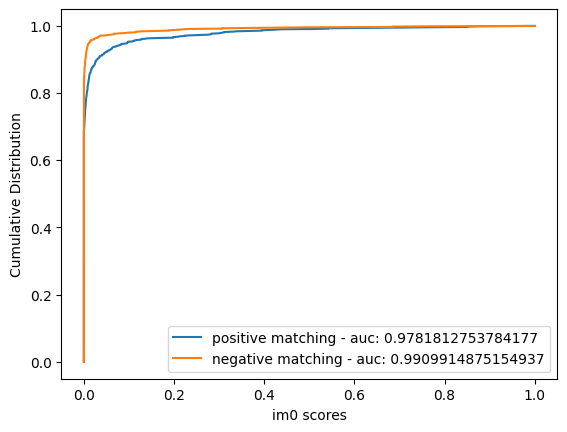

In [197]:
evaluate_auc_triplet(triplet, matcher)